# Quickstart of SuPy

This quickstart demonstrates the essential and simplest workflow of `supy` in SUEWS simulation:

1. [load input files](#Load-input-files)
2. [run simulation](#Run-simulations)
3. [examine results](#Examine-results)

More advanced use of `supy` are available in the [tutorials](./tutorial.rst#tutorials)

Before we start, we need to load the following necessary packages.

In [1]:
import matplotlib.pyplot as plt
import supy as sp
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline

In [2]:
sp.show_version()

SuPy versions
-------------
supy: 2020.7.1dev
supy_driver: 2020b1

SYSTEM DEPENDENCY

INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Darwin
OS-release       : 19.5.0
machine          : x86_64
processor        : i386
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.0.3
numpy            : 1.17.5
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 45.1.0.post20200119
Cython           : None
pytest           : 5.3.1
hypothesis       : None
sphinx           : 3.1.1
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.5.0
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.11.1
pandas_datareader: None
bs4              : 4.8.2
bottleneck       : None
fastparquet      : None

## Load input files

### For existing SUEWS users:

First, a path to SUEWS `RunControl.nml` should be specified, which will direct `supy` to locate input files.

In [3]:
path_runcontrol = Path('../sample_run') / 'RunControl.nml'

In [4]:
df_state_init = sp.init_supy(path_runcontrol)

2020-07-05 22:59:45,696 - SuPy - INFO - All cache cleared.


A sample `df_state_init` looks below (note that `.T` is used here to produce a nicer tableform view):

In [5]:
df_state_init.filter(like='method').T

,grid,1
var,ind_dim,
aerodynamicresistancemethod,0,2
basetmethod,0,1
evapmethod,0,2
emissionsmethod,0,2
netradiationmethod,0,3
roughlenheatmethod,0,2
roughlenmommethod,0,2
smdmethod,0,0
stabilitymethod,0,3


Following the convention of SUEWS, `supy` loads meteorological forcing (met-forcing) files at the grid level.

In [6]:
grid = df_state_init.index[0]
df_forcing = sp.load_forcing_grid(path_runcontrol, grid)
# by default, two years of forcing data are included;
# to save running time for demonstration, we only use one year in this demo
df_forcing=df_forcing.loc['2012'].iloc[1:]

2020-07-05 22:59:47,526 - SuPy - INFO - All cache cleared.


### For new users to SUEWS/SuPy:


To ease the input file preparation, a helper function `load_SampleData` is provided to get the sample input for SuPy simulations 

In [7]:
df_state_init, df_forcing = sp.load_SampleData()
grid = df_state_init.index[0]
# by default, two years of forcing data are included;
# to save running time for demonstration, we only use one year in this demo
df_forcing=df_forcing.loc['2012'].iloc[1:]

2020-07-05 22:59:50,754 - SuPy - INFO - All cache cleared.


### Overview of SuPy input 

#### `df_state_init`

`df_state_init` includes model Initial state consisting of:

* surface characteristics (e.g., albedo, emissivity, land cover fractions, etc.; full details refer to [SUEWS documentation](https://suews-docs.readthedocs.io/en/latest/input_files/SUEWS_SiteInfo/SUEWS_SiteInfo.html))

* model configurations (e.g., stability; full details refer to [SUEWS documentation](https://suews-docs.readthedocs.io/en/latest/input_files/RunControl/RunControl.html))

Detailed description of variables in `df_state_init` refers to [SuPy input](../data-structure/supy-io.ipynb#df_state_init:-model-initial-states)

Surface land cover fraction information in the sample input dataset:

In [8]:
df_state_init.loc[:,['bldgh','evetreeh','dectreeh']]

var,bldgh,dectreeh,evetreeh
ind_dim,0,0,0
grid,,,
1,22.0,13.1,13.1


In [9]:
df_state_init.filter(like='sfr')

var       sfr                                  
ind_dim  (0,)  (1,) (2,)  (3,)  (4,) (5,)  (6,)
grid                                           
1        0.43  0.38  0.0  0.02  0.03  0.0  0.14

#### `df_forcing`

`df_forcing` includes meteorological and other external forcing information.

Detailed description of variables in `df_forcing` refers to [SuPy input](../data-structure/supy-io.ipynb#df_forcing:-forcing-data).

Below is an overview of forcing variables of the sample data set used in the following simulations.

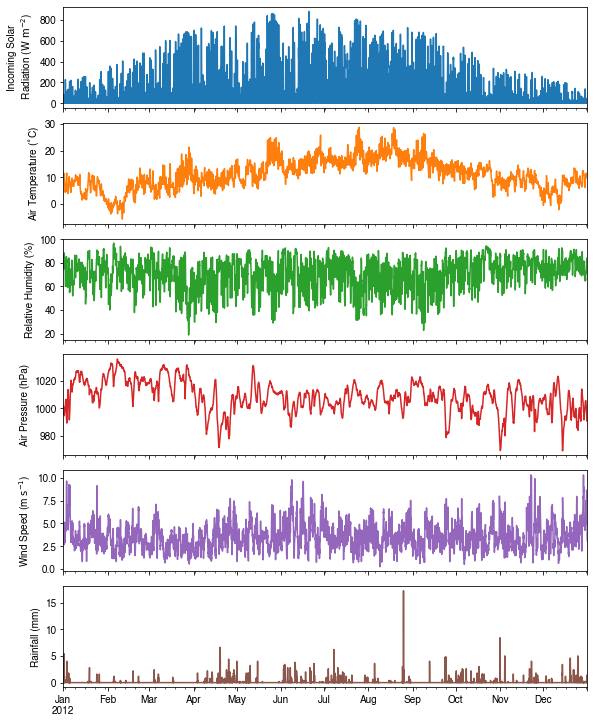

In [10]:
list_var_forcing = [
    "kdown",
    "Tair",
    "RH",
    "pres",
    "U",
    "rain",
]
dict_var_label = {
    "kdown": "Incoming Solar\n Radiation ($ \mathrm{W \ m^{-2}}$)",
    "Tair": "Air Temperature ($^{\circ}}$C)",
    "RH": r"Relative Humidity (%)",
    "pres": "Air Pressure (hPa)",
    "rain": "Rainfall (mm)",
    "U": "Wind Speed (m $\mathrm{s^{-1}}$)",
}
df_plot_forcing_x = (
    df_forcing.loc[:, list_var_forcing].copy().shift(-1).dropna(how="any")
)
df_plot_forcing = df_plot_forcing_x.resample("1h").mean()
df_plot_forcing["rain"] = df_plot_forcing_x["rain"].resample("1h").sum()

axes = df_plot_forcing.plot(subplots=True, figsize=(8, 12), legend=False,)
fig = axes[0].figure
fig.tight_layout()
fig.autofmt_xdate(bottom=0.2, rotation=0, ha="center")
for ax, var in zip(axes, list_var_forcing):
    _ = ax.set_ylabel(dict_var_label[var])

### Modification of SuPy input

Given `pandas.DataFrame` is the core data structure of SuPy, all operations, including modification, output, demonstration, etc., on SuPy inputs (`df_state_init` and `df_forcing`) can be done using `pandas`-based functions/methods.

Specifically, for modification, the following operations are essential:

#### locating data

Data can be located in two ways, namely:
1. by name via [`.loc`](http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#selection-by-label);
2. by position via [`.iloc`](http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#selection-by-position).

In [11]:
# view the surface fraction variable: `sfr`
df_state_init.loc[:,'sfr']

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.43,0.38,0.0,0.02,0.03,0.0,0.14


In [12]:
# view the second row of `df_forcing`, which is a pandas Series
df_forcing.iloc[1]

iy       2012.000000
id          1.000000
it          0.000000
imin       10.000000
qn       -999.000000
qh       -999.000000
qe       -999.000000
qs       -999.000000
qf       -999.000000
U           5.176667
RH         86.195000
Tair       11.620000
pres     1001.833333
rain        0.000000
kdown       0.173333
snow     -999.000000
ldown    -999.000000
fcld     -999.000000
Wuh         0.000000
xsmd     -999.000000
lai      -999.000000
kdiff    -999.000000
kdir     -999.000000
wdir     -999.000000
isec        0.000000
Name: 2012-01-01 00:10:00, dtype: float64

In [13]:
# view a particular position of `df_forcing`, which is a value
df_forcing.iloc[8,9]

4.78

#### setting new values

Setting new values is very straightforward: after locating the variables/data to modify, just set the new values accordingly:

In [14]:
# modify surface fractions
df_state_init.loc[:,'sfr']=[.1,.1,.2,.3,.25,.05,0]
# check the updated values
df_state_init.loc[:,'sfr']

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.1,0.1,0.2,0.3,0.25,0.05,0.0


## Run simulations

Once met-forcing (via `df_forcing`) and initial conditions (via `df_state_init`) are loaded in, we call `sp.run_supy` to conduct a SUEWS simulation, which will return two `pandas` `DataFrame`s: `df_output` and `df_state`.

In [15]:
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init)

2020-07-05 22:59:56,659 - SuPy - INFO - ====================
2020-07-05 22:59:56,660 - SuPy - INFO - Simulation period:
2020-07-05 22:59:56,660 - SuPy - INFO -   Start: 2012-01-01 00:05:00
2020-07-05 22:59:56,661 - SuPy - INFO -   End: 2012-12-31 23:55:00
2020-07-05 22:59:56,662 - SuPy - INFO - 
2020-07-05 22:59:56,662 - SuPy - INFO - No. of grids: 1
2020-07-05 22:59:56,663 - SuPy - INFO - SuPy is running in serial mode
2020-07-05 23:00:15,586 - SuPy - INFO - Execution time: 18.9 s
2020-07-05 23:00:15,587 - SuPy - INFO - ====================



### `df_output`

`df_output` is an ensemble output collection of major SUEWS output groups, including:

* SUEWS: the essential SUEWS output variables
* DailyState: variables of daily state information
* snow: snow output variables (effective when `snowuse = 1` set in `df_state_init`)

Detailed description of variables in `df_output` refers to [SuPy output](../data-structure/supy-io.html#df_output:-model-output-results)

In [16]:
df_output.columns.levels[0]

Index(['SUEWS', 'snow', 'RSL', 'SOLWEIG', 'DailyState'], dtype='object', name='group')

### `df_state_final`

`df_state_final` is a `DataFrame` for holding:

1. all model states if `save_state` is set to `True` when calling `sp.run_supy` (`supy` may run significantly slower for a large simulation);
2. or, only the final state if `save_state` is set to `False` (the default setting), in which mode `supy` has a similar performance as the standalone compiled SUEWS executable.

Entries in `df_state_final` have the same data structure as `df_state_init` and can thus be used for other SUEWS simulations starting at the timestamp as in `df_state_final`.

Detailed description of variables in `df_state_final` refers to [SuPy output](../data-structure/supy-io.html#df_state_final:-model-final-states)

In [17]:
df_state_final.T.head()

datetime                 2012-01-01 00:05:00 2013-01-01 00:00:00
grid                                       1                   1
var              ind_dim                                        
ah_min           (0,)                   15.0                15.0
                 (1,)                   15.0                15.0
ah_slope_cooling (0,)                    2.7                 2.7
                 (1,)                    2.7                 2.7
ah_slope_heating (0,)                    2.7                 2.7

## Examine results

Thanks to the functionality inherited from `pandas` and other packages under the [PyData](https://pydata.org) stack, compared with the standard SUEWS simulation workflow, `supy` enables more convenient examination of SUEWS results by statistics calculation, resampling, plotting (and many more).

### Ouptut structure

`df_output` is organised with `MultiIndex` `(grid,timestamp)` and `(group,varaible)` as `index` and `columns`, respectively.

In [18]:
df_output.head()

group                        SUEWS                                    \
var                          Kdown       Kup       Ldown         Lup   
grid datetime                                                          
1    2012-01-01 00:05:00  0.176667  0.021459  344.179805  371.680316   
     2012-01-01 00:10:00  0.173333  0.046164  344.190048  372.637243   
     2012-01-01 00:15:00  0.170000  0.045271  344.200308  372.715137   
     2012-01-01 00:20:00  0.166667  0.044378  344.210586  372.793044   
     2012-01-01 00:25:00  0.163333  0.043485  344.220882  372.870963   

group                                                                \
var                           Tsurf         QN         QF        QS   
grid datetime                                                         
1    2012-01-01 00:05:00  11.607207 -27.345303  40.574001 -5.886447   
     2012-01-01 00:10:00  11.620000 -28.320026  39.724283 -1.013319   
     2012-01-01 00:15:00  11.635000 -28.390100  38.874566 -1.001900   
     2012-01-01 00:20:00  11.650000 -28.460168  38.024849 -0.989860   
     2012-01-01 00:25:00  11.665000 -28.530232  37.175131 -0.977988   

group                                           ...     DailyState  \
var                              QH         QE  ... DensSnow_Paved   
grid datetime                                   ...                  
1    2012-01-01 00:05:00  15.276915  -7.777741  ...            NaN   
     2012-01-01 00:10:00 -22.518257 -81.748807  ...            NaN   
     2012-01-01 00:15:00 -23.450672 -82.273388  ...            NaN   
     2012-01-01 00:20:00 -24.350304 -82.818868  ...            NaN   
     2012-01-01 00:25:00 -25.191350 -83.410146  ...            NaN   

group                                                                  \
var                      DensSnow_Bldgs DensSnow_EveTr DensSnow_DecTr   
grid datetime                                                           
1    2012-01-01 00:05:00            NaN            NaN            NaN   
     2012-01-01 00:10:00            NaN            NaN            NaN   
     2012-01-01 00:15:00            NaN            NaN            NaN   
     2012-01-01 00:20:00            NaN            NaN            NaN   
     2012-01-01 00:25:00            NaN            NaN            NaN   

group                                                                          \
var                      DensSnow_Grass DensSnow_BSoil DensSnow_Water  a1  a2   
grid datetime                                                                   
1    2012-01-01 00:05:00            NaN            NaN            NaN NaN NaN   
     2012-01-01 00:10:00            NaN            NaN            NaN NaN NaN   
     2012-01-01 00:15:00            NaN            NaN            NaN NaN NaN   
     2012-01-01 00:20:00            NaN            NaN            NaN NaN NaN   
     2012-01-01 00:25:00            NaN            NaN            NaN NaN NaN   

group                         
var                       a3  
grid datetime                 
1    2012-01-01 00:05:00 NaN  
     2012-01-01 00:10:00 NaN  
     2012-01-01 00:15:00 NaN  
     2012-01-01 00:20:00 NaN  
     2012-01-01 00:25:00 NaN  

[5 rows x 371 columns]

Here we demonstrate several typical scenarios for SUEWS results examination.

The essential `SUEWS` output collection is extracted as a separate variable for easier processing in the following sections. More [advanced slicing techniques](http://pandas.pydata.org/pandas-docs/stable/advanced.html#multiindex-advanced-indexing) are available in `pandas` documentation.

In [19]:
df_output_suews = df_output['SUEWS']

### Statistics Calculation

We can use the `.describe()` method for a quick overview of the key surface energy balance budgets.

In [20]:
df_output_suews.loc[:, ['QN', 'QS', 'QH', 'QE', 'QF']].describe()

var,QN,QS,QH,QE,QF
count,105407.000000,105407.000000,105407.000000,105407.000000,105407.000000
mean,39.375516,5.729435,66.614072,46.798096,79.024549
std,131.952334,48.981924,71.535234,70.441795,31.231867
min,-86.331686,-75.287258,-98.890985,-84.805997,26.327536
25%,-42.635690,-27.871115,20.680393,0.960748,50.058031
50%,-26.001734,-7.830453,48.672443,14.846743,82.883410
75%,73.479667,18.009734,91.152469,65.817674,104.812507
max,679.848644,237.932439,480.602696,532.281922,160.023207


### Plotting

#### Basic example
Plotting is very straightforward via the `.plot` method bounded with `pandas.DataFrame`.
Note the usage of `loc` for two slices of the output `DataFrame`.

In [21]:
# a dict for better display variable names
dict_var_disp = {
    'QN': '$Q^*$',
    'QS': r'$\Delta Q_S$',
    'QE': '$Q_E$',
    'QH': '$Q_H$',
    'QF': '$Q_F$',
    'Kdown': r'$K_{\downarrow}$',
    'Kup': r'$K_{\uparrow}$',
    'Ldown': r'$L_{\downarrow}$',
    'Lup': r'$L_{\uparrow}$',
    'Rain': '$P$',
    'Irr': '$I$',
    'Evap': '$E$',
    'RO': '$R$',
    'TotCh': '$\Delta S$',
}

Quick look at the simulation results:

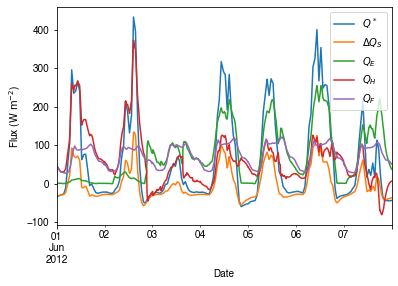

In [22]:
ax_output = df_output_suews\
    .loc[grid]\
    .loc['2012 6 1':'2012 6 7',
         ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot()
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

#### More examples
Below is a more complete example for examination of urban energy balance over the whole summer (June to August).

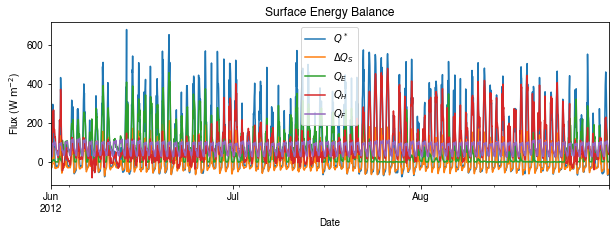

In [23]:
# energy balance
ax_output = (
    df_output_suews.loc[grid]
    .loc["2012 6":"2012 8", ["QN", "QS", "QE", "QH", "QF"]]
    .rename(columns=dict_var_disp)
    .plot(figsize=(10, 3), title="Surface Energy Balance",)
)
_ = ax_output.set_xlabel("Date")
_ = ax_output.set_ylabel("Flux ($ \mathrm{W \ m^{-2}}$)")
_ = ax_output.legend()

### Resampling

The suggested runtime/simulation frequency of SUEWS is `300 s`, which usually results in a large output and may be over-weighted for storage and analysis. 
Also, you may feel an apparent slowdown in producing the above figure as a large amount of data were used for the plotting.
To slim down the result size for analysis and output, we can `resample` the default output very easily.

In [24]:
rsmp_1d = df_output_suews.loc[grid].resample("1d")
# daily mean values
df_1d_mean = rsmp_1d.mean()
# daily sum values
df_1d_sum = rsmp_1d.sum()

We can then re-examine the above energy balance at hourly scale and plotting will be significantly faster.

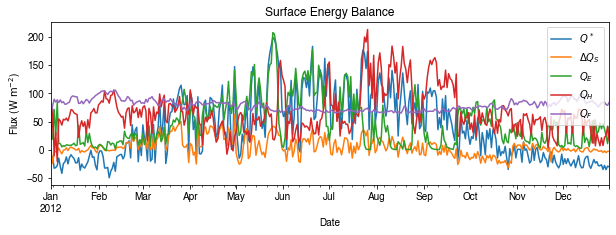

In [25]:
# energy balance
ax_output = (
    df_1d_mean.loc[:, ["QN", "QS", "QE", "QH", "QF"]]
    .rename(columns=dict_var_disp)
    .plot(figsize=(10, 3), title="Surface Energy Balance",)
)
_ = ax_output.set_xlabel("Date")
_ = ax_output.set_ylabel("Flux ($ \mathrm{W \ m^{-2}}$)")
_ = ax_output.legend()

Then we use the hourly results for other analyses.

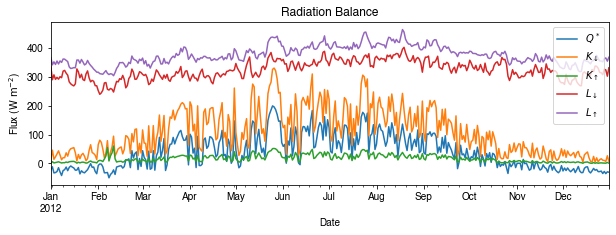

In [26]:
# radiation balance
ax_output = (
    df_1d_mean.loc[:, ["QN", "Kdown", "Kup", "Ldown", "Lup"]]
    .rename(columns=dict_var_disp)
    .plot(figsize=(10, 3), title="Radiation Balance",)
)
_ = ax_output.set_xlabel("Date")
_ = ax_output.set_ylabel("Flux ($ \mathrm{W \ m^{-2}}$)")
_ = ax_output.legend()

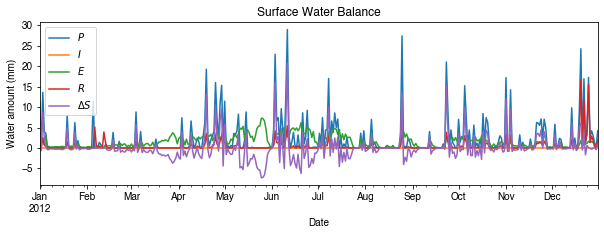

In [27]:
# water balance
ax_output = (
    df_1d_sum.loc[:, ["Rain", "Irr", "Evap", "RO", "TotCh"]]
    .rename(columns=dict_var_disp)
    .plot(figsize=(10, 3), title="Surface Water Balance",)
)
_ = ax_output.set_xlabel("Date")
_ = ax_output.set_ylabel("Water amount (mm)")
_ = ax_output.legend()

Get an overview of partitioning in energy and water balance at monthly scales:

In [28]:
# get a monthly Resampler
df_plot = df_output_suews.loc[grid].copy()
df_plot.index = df_plot.index.set_names("Month")
rsmp_1M = df_plot.shift(-1).dropna(how="all").resample("1M", kind="period")
# mean values
df_1M_mean = rsmp_1M.mean()
# sum values
df_1M_sum = rsmp_1M.sum()

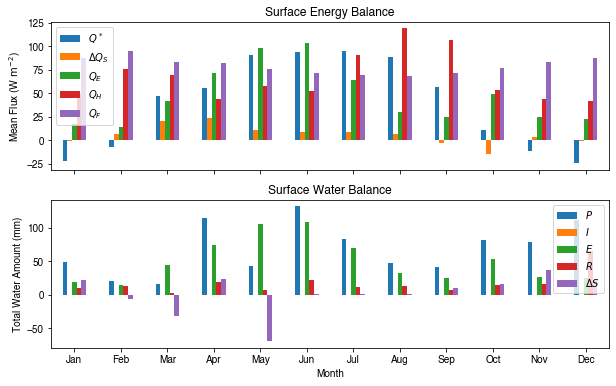

In [29]:
# month names
name_mon = [x.strftime("%b") for x in rsmp_1M.groups]
# create subplots showing two panels together
fig, axes = plt.subplots(2, 1, sharex=True)
# surface energy balance
df_1M_mean.loc[:, ["QN", "QS", "QE", "QH", "QF"]].rename(columns=dict_var_disp).plot(
    ax=axes[0],  # specify the axis for plotting
    figsize=(10, 6),  # specify figure size
    title="Surface Energy Balance",
    kind="bar",
)
# surface water balance
df_1M_sum.loc[:, ["Rain", "Irr", "Evap", "RO", "TotCh"]].rename(
    columns=dict_var_disp
).plot(
    ax=axes[1],  # specify the axis for plotting
    title="Surface Water Balance",
    kind="bar",
)

# annotations
_ = axes[0].set_ylabel("Mean Flux ($ \mathrm{W \ m^{-2}}$)")
_ = axes[0].legend()
_ = axes[1].set_xlabel("Month")
_ = axes[1].set_ylabel("Total Water Amount (mm)")
_ = axes[1].xaxis.set_ticklabels(name_mon, rotation=0)
_ = axes[1].legend()

### Output

The supy output can be saved as `txt` files for further analysis using supy function `save_supy`.

In [30]:
df_output

group                        SUEWS                                    \
var                          Kdown       Kup       Ldown         Lup   
grid datetime                                                          
1    2012-01-01 00:05:00  0.176667  0.021459  344.179805  371.680316   
     2012-01-01 00:10:00  0.173333  0.046164  344.190048  372.637243   
     2012-01-01 00:15:00  0.170000  0.045271  344.200308  372.715137   
     2012-01-01 00:20:00  0.166667  0.044378  344.210586  372.793044   
     2012-01-01 00:25:00  0.163333  0.043485  344.220882  372.870963   
...                            ...       ...         ...         ...   
     2012-12-31 23:35:00  0.000000  0.000000  330.263407  363.676342   
     2012-12-31 23:40:00  0.000000  0.000000  330.263407  363.676342   
     2012-12-31 23:45:00  0.000000  0.000000  330.263407  363.676342   
     2012-12-31 23:50:00  0.000000  0.000000  330.263407  363.676342   
     2012-12-31 23:55:00  0.000000  0.000000  330.263407  363.676342   

group                                                                \
var                           Tsurf         QN         QF        QS   
grid datetime                                                         
1    2012-01-01 00:05:00  11.607207 -27.345303  40.574001 -5.886447   
     2012-01-01 00:10:00  11.620000 -28.320026  39.724283 -1.013319   
     2012-01-01 00:15:00  11.635000 -28.390100  38.874566 -1.001900   
     2012-01-01 00:20:00  11.650000 -28.460168  38.024849 -0.989860   
     2012-01-01 00:25:00  11.665000 -28.530232  37.175131 -0.977988   
...                             ...        ...        ...       ...   
     2012-12-31 23:35:00  10.140000 -33.412935  53.348682 -4.399144   
     2012-12-31 23:40:00  10.140000 -33.412935  52.422737 -4.397669   
     2012-12-31 23:45:00  10.140000 -33.412935  51.496792 -4.395831   
     2012-12-31 23:50:00  10.140000 -33.412935  50.570847 -4.393681   
     2012-12-31 23:55:00  10.140000 -33.412935  46.174492 -4.391264   

group                                           ...     DailyState  \
var                              QH         QE  ... DensSnow_Paved   
grid datetime                                   ...                  
1    2012-01-01 00:05:00  15.276915  -7.777741  ...            NaN   
     2012-01-01 00:10:00 -22.518257 -81.748807  ...            NaN   
     2012-01-01 00:15:00 -23.450672 -82.273388  ...            NaN   
     2012-01-01 00:20:00 -24.350304 -82.818868  ...            NaN   
     2012-01-01 00:25:00 -25.191350 -83.410146  ...            NaN   
...                             ...        ...  ...            ...   
     2012-12-31 23:35:00   2.559974  21.774918  ...            NaN   
     2012-12-31 23:40:00   2.178582  21.228889  ...            NaN   
     2012-12-31 23:45:00   1.797190  20.682498  ...            NaN   
     2012-12-31 23:50:00   1.436708  20.114885  ...            NaN   
     2012-12-31 23:55:00  -0.234230  17.387051  ...          100.0   

group                                                                  \
var                      DensSnow_Bldgs DensSnow_EveTr DensSnow_DecTr   
grid datetime                                                           
1    2012-01-01 00:05:00            NaN            NaN            NaN   
     2012-01-01 00:10:00            NaN            NaN            NaN   
     2012-01-01 00:15:00            NaN            NaN            NaN   
     2012-01-01 00:20:00            NaN            NaN            NaN   
     2012-01-01 00:25:00            NaN            NaN            NaN   
...                                 ...            ...            ...   
     2012-12-31 23:35:00            NaN            NaN            NaN   
     2012-12-31 23:40:00            NaN            NaN            NaN   
     2012-12-31 23:45:00            NaN            NaN            NaN   
     2012-12-31 23:50:00            NaN            NaN            NaN   
     2012-12-31 23:55:00          100.0          100.0          10

In [33]:
list_path_save = sp.save_supy(df_output, df_state_final,)

In [32]:
for file_out in list_path_save:
    print(file_out.name)

1_2012_DailyState.txt
1_2012_SUEWS_60.txt
1_2012_snow_60.txt
1_2012_RSL_60.txt
1_2012_SOLWEIG_60.txt
df_state.csv
